In [1]:
import pandas as pd
import re
import numpy as np
pd.__version__

'0.24.2'

In [2]:
from platform import python_version

print(python_version())

3.6.8


In [7]:
# create a list of values prof. Naylor used as "N/A"
na_values = ["not_applicable", "not_specified", "--", " "]
# Read in Excel file.
df = pd.read_excel(
    "Comprehensive List of Enslaved People at Rose Hall Estate, 1817-1832.xlsx", 
    na_values=na_values)
# create a new list of column names that are easier to type
column_mapping = {
    'id_for_digital_project': "id", 
    'name': "name",
    'other_versions_of_name_in_the_records': "nameOther",
    'christian_names_often_combined_with_surname_in_1832_list_in_old_st_james_book': "christianNames",
    'names_of_married_women_and_surnames_for_children_listed_in_1832_list_in_old_st_james_book': "marriedWomenChildrenSurnames",
    'country': "country", 
    'colour': "colour", 
    'gender': "gender", 
    'age_on_1817_list': "age1817List",
    'familial_connections': "family", 
    'mother': "mother", 
    'id_of_mother': "motherId", 
    'grandmother': "grandmother",
    'id_of_grandmother': "grandmotherId", 
    'great grandmother': "greatGrandmother", 
    'id_of_great_grandmother': "greatGrandmotherId",
    'my_additional_comments': "naylorComments", 
    '_rose_hall_journal_info': "journalInfo",
    'age_1817_registry': "age1817", 
    'age_1820_registry': "age1820", 
    'age_1823_registry': "age1823",
    'age_1826_registry': "age1826", 
    'age_1829_registry': "age1829", 
    'age_1832_registry': "age1832",
    'age_1832_list_in_old_st_james_book': "age1832osjb",
    'primary_duties_and_positions_1832_list_in_old_st_james_book': "primaryDuties",
    'condition_1832_list_in_old_st_james_book': "condition",
    'disposition_1832_list_in_old_st_james_book': "disposition",
    'valuation_1832_list_in_old_st_james_book': "valuation",
    'Unnamed: 29': None, # Not needed
    'Unnamed: 30': None,
    'Unnamed: 31': None,
    'Unnamed: 32': None,
    'Unnamed: 33': None,
    'Unnamed: 34': None,
    'Unnamed: 35': None,
    'Unnamed: 36': None,
    'Unnamed: 37': None,
    'Unnamed: 38': None,
    'Unnamed: 39': None
}
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]
# Rename columns.
df = df[columns].rename(columns=column_mapping)
# Drop supplemental rows that include information prof. Naylor added that will break the website.
df.drop([i for i in range(208,221)], inplace=True)

In [8]:
# Create a column for reason for leaving Rose Hall.
# This column is a number, "Dead," or "Transported."
df["reasonForLeaving"] = ""
# Fill Column for reason for leaving based on information in age1832osjb
def ageDeadOrTransported(person):
    age = person["age1832osjb"]
    if isinstance(age, int) or isinstance(age, float):
        return age
    else:
        if "Dea" in age:
            return "Dead"
        elif "Transported" in age:
            return "Transported"
        elif "(" in age:
            age = re.sub(r'\(.*\)', '', age)
            age = re.sub(r' ', '', age)
            return int(age)
        elif "1832-List at age" in age:
            age = age.replace("1832-List at age ", "")
            return int(age)
        elif "." in age:
            age = age.replace(" yr", "")
            return float(age)
        else:
            return np.nan

df["reasonForLeaving"] = df.apply(ageDeadOrTransported, axis=1)

#print(pd.unique(df["age1832osjb"].values))
#print(pd.unique(df["reasonForLeaving"].values))

In [9]:
def parseAge(value):
    if isinstance(value, int) or isinstance(value, float):
        return value
    else:
        if "(" in value:
            value = re.sub(r'\(.*\)', '', value)
            value = re.sub(r' ', '', value)

        if value == "2 1/2 years":
            return 2.5
        elif re.search(r'^\d+ mths$', value):
            value = value.replace(" mths", "")
            return int(value)/12
        elif re.search(r'^\d+ days', value):
            value = value.replace("-Dead", "")
            value = value.replace(" days", "")
            return int(value)/365
        elif value == "2 yrs and 5 mths":
            return 2 + 5/12
        elif value == "1 yr 5 mths":
            return 1 + 5/12
        elif value == "3 weeks":
            return 3/52
        elif value == "6 mths or 18 mths?":
            return 0.5
        elif value == "3 mths-Dead":
            return 1/4
        elif value == "8 mths-Dead":
            return 8/12

        elif value == "List-Dead at 42":
            return 42
        elif "birth listed in this 1832 slave register" in value:
            return np.nan
        elif value == "7 days-Dead":
            return 7/365
        elif value == "Dead":
            return np.nan

        if re.search(r'^\d+-Dead', value):
            value = value.replace("-Dead", "")
            return int(value)
        else: 
            return int(value)

In [10]:
# Calculate the birth year using ages.
def calculateBirthYear(person):
    if (
        isinstance(person["age1817"], int) or isinstance(person["age1817"], float)
        ) and not np.isnan(person["age1817"]):
        return [person["age1817"], 1817 - person["age1817"]]
    elif (isinstance(person["age1817List"], float) and not np.isnan(person["age1817List"])):
        return [person["age1817List"], 1817 - person["age1817List"]]
    else: 
        years = [1820, 1823, 1826, 1829, 1832]
        ages = {}
        for year in years:
            key = "age" + str(year)
            ages[key] = parseAge(person[key])
        for year in years:
            key = "age" + str(year)
            if (isinstance(ages[key], int) or isinstance(ages[key], float)) and not np.isnan(ages[key]):
                return [ages[key], year - ages[key]]
    
        if (np.isnan(ages["age1832"]) and 
            not isinstance(person["reasonForLeaving"], str) and
            not np.isnan(person["reasonForLeaving"])
           ):
            age = parseAge(person["reasonForLeaving"])
            return [age, 1832 - age]
    return [np.nan, np.nan]

agesAndBirthYears = df.apply(calculateBirthYear, axis=1)
df["parsedAge"] = list(map(lambda x: x[0], agesAndBirthYears))
df["birthYear"] = list(map(lambda x: x[1], agesAndBirthYears)) 



<AxesSubplot:>

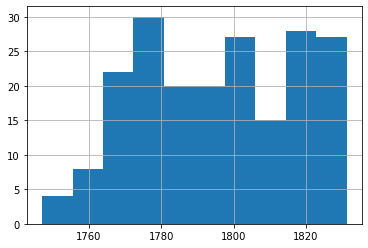

In [11]:
df["birthYear"].hist()

In [12]:
def calculateLeavingYear(person):
    if np.isnan(person["birthYear"]):
        return np.nan
    
    if person["reasonForLeaving"] == "Dead" or person["reasonForLeaving"] == "Transported":
        years = [1820, 1823, 1826, 1829, 1832]
        for year in years:
            key = "age" + str(year)
            if (isinstance(person[key], str) and 
                ("Dea" in person[key] or "Transported" in person[key])
               ):
                return year

    return 1832
    
df["leavingYear"] = df.apply(calculateLeavingYear, axis=1)

<AxesSubplot:>

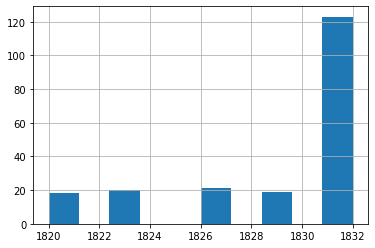

In [13]:
df["leavingYear"].hist()